This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [25]:
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dendropy
from dendropy.calculate import treecompare
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as mticker

import os
from collections import Counter
import seaborn as sns
import json
from sklearn.metrics import adjusted_rand_score

from src_python.mutation_filter import MutationFilter
from src_python.cell_tree import CellTree
from src_python.mutation_tree import MutationTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, create_mutation_matrix, \
    create_genotype_matrix, mut_count_distance
from dendropy import Tree, TreeList, TaxonNamespace

In [2]:
path = "../data/simulated_data"

n_cells = [50]
n_mut = [500]
n_tests = 100
clones = [5, 10, 20, ""]
stratified = ""  # "_stratified" # stratified means all clones are about equally large

use_summary_statistics = False #True # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False
genotype_differences = {"SCITE-RNA": {}}
path_len_differences = {"SCITE-RNA": {}}
likelihood_differences = {"SCITE-RNA": {}}
mut_count_differences = {"SCITE-RNA": {}}
adjusted_rand_index = {"SCITE-RNA": {}}

In [3]:
def normalize_split(split):
    A, B = map(set, split)

    # Remove trivial splits (less than 2 leaves on either side)
    if len(A) < 2 or len(B) < 2:
        return None

    # Create frozensets for each side
    side1 = frozenset(A)
    side2 = frozenset(B)

    # Return a canonical bipartition as frozenset of frozensets (order insensitive)
    return frozenset([side1, side2])

def get_splits(ct, node, labels=None):
    splits = []
    for child in ct.dfs_experimental(node):
        if ct.isleaf(child):
            continue

        child_leaves = [leaf for leaf in ct.leaves(child)]
        other_partition = [leaf for leaf in labels if leaf not in child_leaves]

        if 0 < len(child_leaves) < len(labels):
            splits.append((child_leaves, other_partition))

    return splits

def rf_distance_new(ct1, ct2):
    labels = list(ct1.leaves(ct1.main_root))
    n = len(labels)

    splits1_raw = get_splits(ct1, ct1.main_root, labels)
    splits2_raw = get_splits(ct2, ct2.main_root, labels)

    splits1 = set()
    for split in splits1_raw:
        norm = normalize_split(split)
        if norm is not None:
            splits1.add(norm)

    splits2 = set()
    for split in splits2_raw:
        norm = normalize_split(split)
        if norm is not None:
            splits2.add(norm)

    # Robinson-Foulds distance = number of differing bipartitions
    dist = len(splits1.symmetric_difference(splits2))
    return dist

def annotate_clade_frequencies(tree, split_counter, total_trees):
    """
    Annotates each internal node in the consensus tree with its clade frequency
    based on a user-provided split_counter.
    Frequencies are stored in node.label (string, formatted to 2 decimals).
    """
    for node in tree.postorder_node_iter():
        if node.is_leaf():
            continue

        # Get leaf labels on each side of the split
        node_leaves = set(int(leaf.taxon.label) for leaf in node.leaf_iter())
        rest_leaves = set(int(leaf.taxon.label) for leaf in tree.leaf_node_iter()) - node_leaves

        if len(node_leaves) < 2 or len(rest_leaves) < 2:
            continue  # Not a valid split

        split = frozenset([frozenset(node_leaves), frozenset(rest_leaves)])
        freq = split_counter.get(split, 0) / total_trees
        node.label = f"{freq:.3f}"

In [4]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def compute_split_similarity(s1, s2):
    A1, B1 = s1
    A2, B2 = s2

    A1, B1, A2, B2 = map(set, (A1, B1, A2, B2))

    sim1 = len(A1 & A2) + len(B1 & B2)
    sim2 = len(A1 & B2) + len(B1 & A2)

    return max(sim1, sim2)

def normalize_split_explicit(split):
    A, B = map(set, split)
    if len(A) < 2 or len(B) < 2:
        return None
    return (A, B)

def get_explicit_splits(ct, node, labels):
    splits = []
    for child in ct.dfs_experimental(node):
        if ct.isleaf(child):
            continue
        child_leaves = set(ct.leaves(child))
        other_partition = set(labels) - child_leaves
        if 0 < len(child_leaves) < len(labels):
            split = normalize_split_explicit((child_leaves, other_partition))
            if split:
                splits.append(split)
    return splits

def split_similarity_score(ct1, ct2):
    labels = list(ct1.leaves(ct1.main_root))

    splits1 = get_explicit_splits(ct1, ct1.main_root, labels)
    splits2 = get_explicit_splits(ct2, ct2.main_root, labels)

    if not splits1 or not splits2:
        return 0.0

    # Build similarity matrix
    sim_matrix = np.zeros((len(splits1), len(splits2)))
    for i, s1 in enumerate(splits1):
        for j, s2 in enumerate(splits2):
            sim_matrix[i][j] = compute_split_similarity(s1, s2)

    # Maximize sum of similarities (Hungarian algorithm minimizes, so negate)
    row_ind, col_ind = linear_sum_assignment(-sim_matrix)
    match_score = sim_matrix[row_ind, col_ind].sum()

    # Compute normalization using self-similarity
    self_matrix = np.zeros((len(splits1), len(splits1)))
    for i, s1 in enumerate(splits1):
        for j, s2 in enumerate(splits1):
            self_matrix[i][j] = compute_split_similarity(s1, s2)

    self_row, self_col = linear_sum_assignment(-self_matrix)
    self_score = self_matrix[self_row, self_col].sum()

    if self_score == 0:
        return 0.0  # Avoid divide by zero

    return match_score / self_score

In [5]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

def rf_distance(ct1, ct2):
    n_cells = ct1.n_cells
    newick1 = to_newick(ct1, ct1.main_root) + ";"
    newick2 = to_newick(ct2, ct2.main_root) + ";"

    taxa = dendropy.TaxonNamespace([str(i) for i in range(n_cells)])
    tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
    tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

    rf_distance = treecompare.unweighted_robinson_foulds_distance(tree1, tree2)
    return rf_distance

In [6]:
def expected_genotype_matrix(ct, parent_vec, attachment_probs, gt1, gt2, selected, mut_loc_max):
    """
    Computes the expected genotype matrix (cells x mutations), weighted by attachment probabilities.

    Args:
        ct: object with .flipped attribute (array of shape n_mutations)
        parent_vec: parent vector of the tree (length n_nodes)
        attachment_probs: (n_nodes, n_mutations) attachment probability matrix
        gt1, gt2: base genotype matrices used in your genotype function
        selected: cell selection used in your genotype function

    Returns:
        expected_gt: (n_cells, n_mutations) float matrix, expected genotype matrix
    """
    n_nodes, n_mut = attachment_probs.shape
    n_cells = ct.n_cells
    # attachment_probs = np.zeros((n_nodes, n_mut))
    # for n, i in enumerate(mut_loc_max):
    #     attachment_probs[i,n] = 1

    expected_gt = np.zeros((n_cells, n_mut), dtype=np.float32)

    for node in range(n_nodes):
        # Attach each mutation at this node
        mut_loc = np.full(n_mut, node)

        mut_matrix = create_mutation_matrix(parent_vec, mut_loc, ct)

        # Generate genotype matrix for this attachment
        gt = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct.flipped)  # shape: (n_cells, n_mut)
        gt = vectorized_map(gt)
        # Weight this by the attachment probabilities for that node
        weights = attachment_probs[node]  # shape: (n_mut,)
        weights_selected = np.zeros(len(weights))
        for n, mut in enumerate(selected):
            weights_selected[mut] = weights[n]
        expected_gt += gt * weights_selected   # broadcasting over rows (cells)

    return expected_gt  # apply your VAF transformation

In [7]:
n_round = 0

config = load_config_and_set_random_seed()

mf = MutationFilter(error_rate=config["error_rate"], overdispersion=config["overdispersion"],
                                    genotype_freq=config["genotype_freq"], mut_freq=config["mut_freq"],
                                    dropout_alpha=config["dropout_alpha"], dropout_beta=config["dropout_beta"],
                                    dropout_direction_prob=config["dropout_direction"],
                                    overdispersion_h=config["overdispersion_h"])
#
# if not use_summary_statistics:
#     for n_c, n_m in zip(n_cells, n_mut):
#         genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
#         path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
#         likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
#         mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
#         for clone in clones:
#             differences = []
#             path_len_distances = []
#             likelihoods = []
#             mut_count_distances = []
#
#             for t in range(n_tests):
#                 base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
#                 genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
#                 genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
#                 ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
#                 alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
#
#                 genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
#                 # print(np.count_nonzero(genotype_pred == "H"), "H pred")
#                 gt = np.loadtxt(genotype_path, dtype=str)
#                 # print(np.count_nonzero(gt == "H"), "H gt")
#                 alt = np.loadtxt(alt_path)
#                 ref = np.loadtxt(ref_path)
#                 true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
#                 sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)
#
#                 mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
#                 vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
#                 genotype_predicted = vectorized_map(genotype_pred)
#                 genotype_gt = vectorized_map(gt)
#                 unique_genotypes = np.unique(genotype_gt, axis=0)
#
#                 # difference = np.mean(np.abs(genotype_predicted - genotype_gt))
#                 # differences.append(difference)
#
#                 flipped_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_flipped", f"sciterna_flipped_{n_round}r{t}.txt"), dtype=float)
#                 selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
#                 gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
#                 # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)
#                 mut_location_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_mutation_location", f"sciterna_mutation_location_{n_round}r{t}.txt"), dtype=int)
#                 mut_location = np.loadtxt(os.path.join(base_path, "mutation_location", f"mutation_location_{t}.txt"), dtype=int)
#                 attachment_probs = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_attachment_probs", f"sciterna_attachment_probs_{n_round}r{t}.txt"), dtype=float)
#
#                 ct_gt = CellTree(n_c)
#                 # ct_gt.fit_llh(llh_1, llh_2)
#                 ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)
#                 # ct_sciterna.fit_llh(llh_1, llh_2)
#
#                 ct_gt.use_parent_vec(true_parent_vec)
#                 ct_gt.mut_loc = mut_location[selected]
#
#                 ct_sciterna.use_parent_vec(sciterna_parent_vec)
#                 ct_sciterna.flipped = flipped_sciterna
#
#                 # n_true_clones = len(np.unique(genotype_gt, axis=0, return_counts=True)[0]) - 1
#                 # ct_sciterna.update_mut_loc_experimental(n_true_clones)
#
#                 mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
#                 path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
#
#                 ct_sciterna.mut_loc = mut_location_sciterna
#                 mut_matrix = create_mutation_matrix(sciterna_parent_vec, ct_sciterna.mut_loc, ct_sciterna)
#                 genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_sciterna.flipped)
#                 genotype_matrix = vectorized_map(genotype_matrix)
#
#                 # expected_genotype = expected_genotype_matrix(ct_sciterna, sciterna_parent_vec, attachment_probs, gt1, gt2, selected, mut_location_sciterna)
#                 #
#                 # os.makedirs(os.path.join(base_path, "sciterna", "sciterna_genotype_marginal"), exist_ok=True)
#                 # np.savetxt(os.path.join(base_path, "sciterna", "sciterna_genotype_marginal", f"sciterna_genotype_marginal_{n_round}r{t}.txt"), expected_genotype)
#                 # expected_genotype = np.round(expected_genotype * 2) / 2
#                 # difference = np.mean(np.abs(expected_genotype - genotype_gt))
#                 difference = np.mean(np.abs(genotype_matrix - genotype_gt))
#                 differences.append(difference)
#
#                 # m_dist = mut_count_distance(genotype_gt, genotype_matrix)
#                 # mut_count_distances.append(m_dist)
#
#                 # likelihoods.append((ct_sciterna.joint - ct_gt.joint) / (ct_sciterna.n_cells * ct_sciterna.n_mut))
#
#                 # graph_gt = ct_gt.to_graphviz()
#                 #
#                 # unique_mut_locs = set(ct_gt.mut_loc)
#                 # colors = list(["red", "blue", "green", "orange", "lightblue"])  # Using CSS color names
#                 # mut_loc_color_map = {mut_loc: colors[i % len(colors)] for i, mut_loc in enumerate(unique_mut_locs)}
#                 #
#                 # new_body_gt = []
#                 # for line in graph_gt.body:
#                 #     if '->' in line and 'label="' in line:
#                 #         label_match = re.search(r'label="([^"]*)"', line)
#                 #         if label_match:
#                 #             label_val = label_match.group(1)
#                 #             if label_val:
#                 #                 first_mut = int(label_val.split(',')[0])
#                 #                 fontcolor = mut_loc_color_map.get(ct_gt.mut_loc[first_mut], 'black')
#                 #                 line = line.replace(']', f', fontcolor="{fontcolor}"]')
#                 #     new_body_gt.append(line)
#                 #
#                 # graph_gt.body = new_body_gt
#                 #
#                 # graph_sciterna = ct_sciterna.to_graphviz()
#                 #
#                 # new_body_sciterna = []
#                 # for line in graph_sciterna.body:
#                 #     if '->' in line and 'label=' in line:
#                 #         # Extract the label value, accounting for both quoted and unquoted labels
#                 #         label_match = re.search(r'label=(["\']?)([^\'"\s]*)\1', line)
#                 #         if label_match:
#                 #             label_val = label_match.group(2)
#                 #             if label_val:
#                 #                 # Split the label into parts if it contains commas
#                 #                 muts = label_val.split(',')
#                 #                 # Use the first mutation ID
#                 #                 first_mut = int(muts[0])
#                 #                 fontcolor = mut_loc_color_map.get(ct_gt.mut_loc[first_mut], 'black')
#                 #                 # Replace or add the fontcolor attribute
#                 #                 if ']' in line:
#                 #                     line = line.replace(']', f', fontcolor="{fontcolor}"]')
#                 #                 else:
#                 #                     line = line.rstrip() + f' fontcolor="{fontcolor}"]'
#                 #     new_body_sciterna.append(line)
#                 #
#                 # graph_sciterna.body = new_body_sciterna
#                 #
#                 # graph_gt.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_gt_{t}.png"), format='png', cleanup=True)
#                 # graph_sciterna.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_sciterna_{n_round}r{t}.png"), format='png', cleanup=True)
#                 # sns.heatmap(genotype_gt)
#                 # plt.title(f"Genotype Matrix GT {t}")
#                 # plt.show()
#                 # sns.heatmap(genotype_predicted)
#                 # plt.title(f"Genotype Matrix Predicted {t}")
#                 # plt.show()
#                 #
#                 # sns.heatmap(np.abs(genotype_gt - genotype_predicted))
#                 # plt.title(f"Genotype Matrix Difference {t}")
#                 # plt.show()
#                 #
#                 # sns.heatmap(alt/(alt + ref))
#                 # plt.title(f"VAF Matrix {t}")
#                 # plt.show()
#
#             genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences
#             path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
#             likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = likelihoods
#             mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
#             print(np.mean(differences), " mean abs difference of vafs predicted")
#             print(np.mean(path_len_distances), " mean path length distance")
#             # print(np.mean(likelihoods), " mean likelihood difference")
#             print(np.mean(mut_count_distances), " mean mutation count distance")

In [11]:
genotype_differences["SCITE-RNA"] = {}
path_len_differences["SCITE-RNA"] = {}
likelihood_differences["SCITE-RNA"] = {}
mut_count_differences["SCITE-RNA"] = {}
adjusted_rand_index["SCITE-RNA"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")

                gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if gt.ndim == 1:
                    gt = gt[:, np.newaxis]

                _, clones_gt = np.unique(gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sciterna", "sciterna_clones", f"sciterna_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec_clustering", f"sciterna_parent_vec_clustering_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)


                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.049231000000000004  mean abs difference of vafs predicted
3.074310204081633  mean path length distance
4.6749519038076155  mean mutation count distance
0.4311650335279578  mean adjusted rand index
0.0750946  mean abs difference of vafs predicted
2.6696244897959183  mean path length distance
6.009170741482967  mean mutation count distance
0.4168188187358192  mean adjusted rand index
0.0861688  mean abs difference of vafs predicted
2.3118857142857148  mean path length distance
5.87511991983968  mean mutation count distance
0.44612780878653197  mean adjusted rand index
0.06307239999999999  mean abs difference of vafs predicted
2.3733142857142853  mean path length distance
4.239179078156312  mean mutation count distance
1.0  mean adjusted rand index


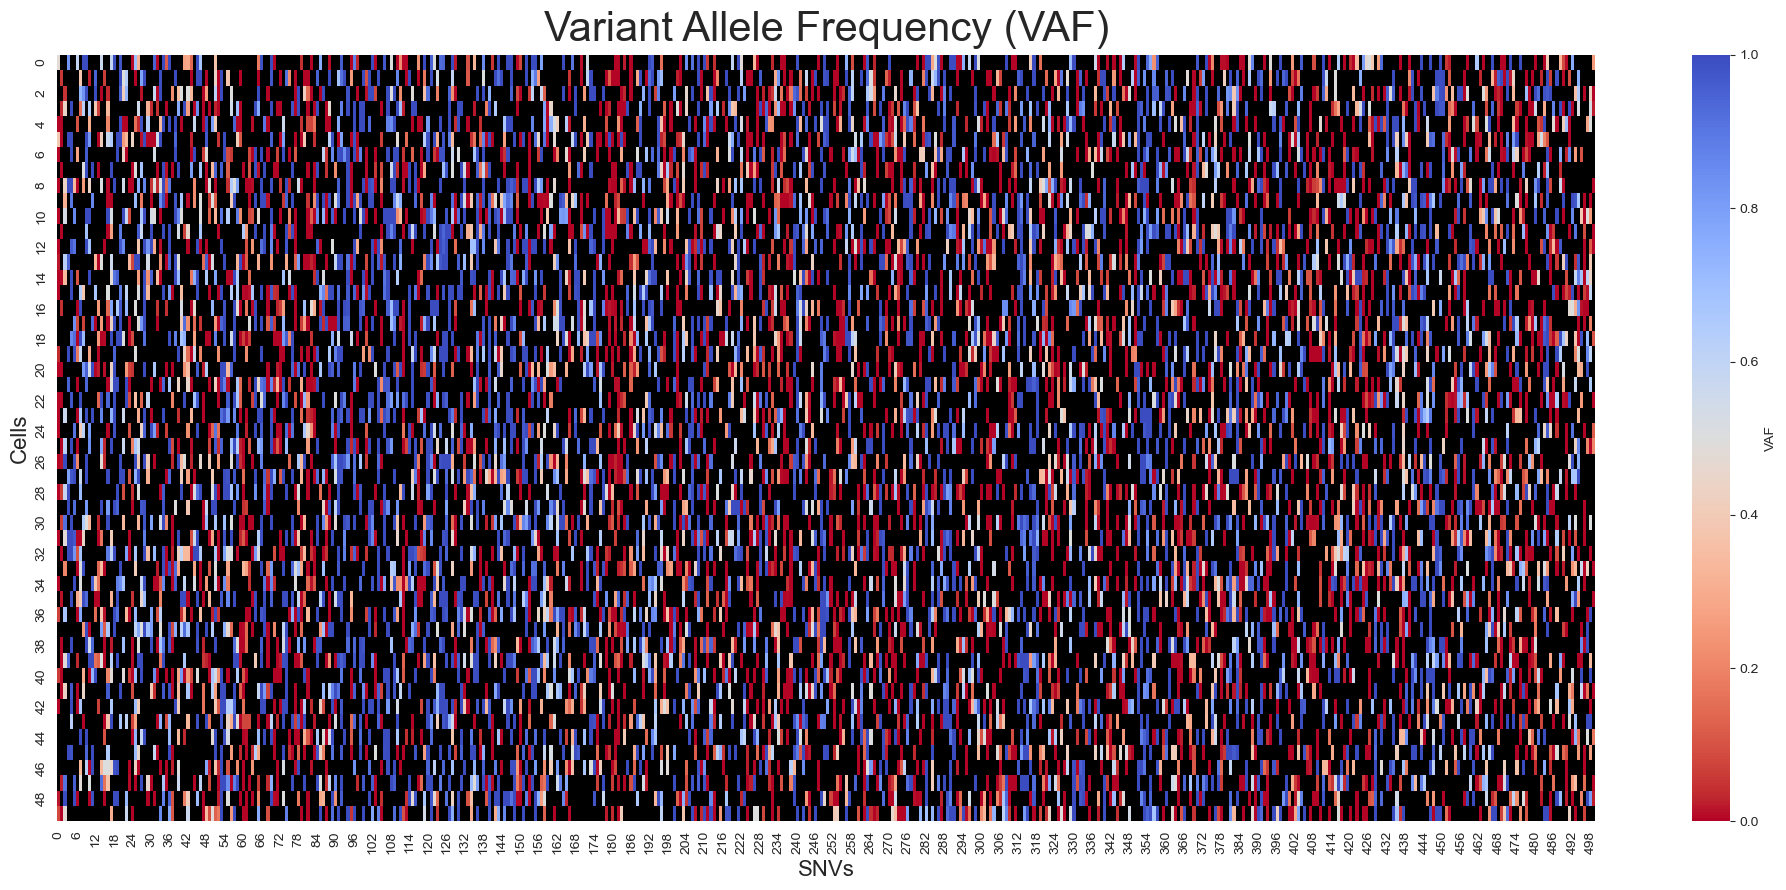

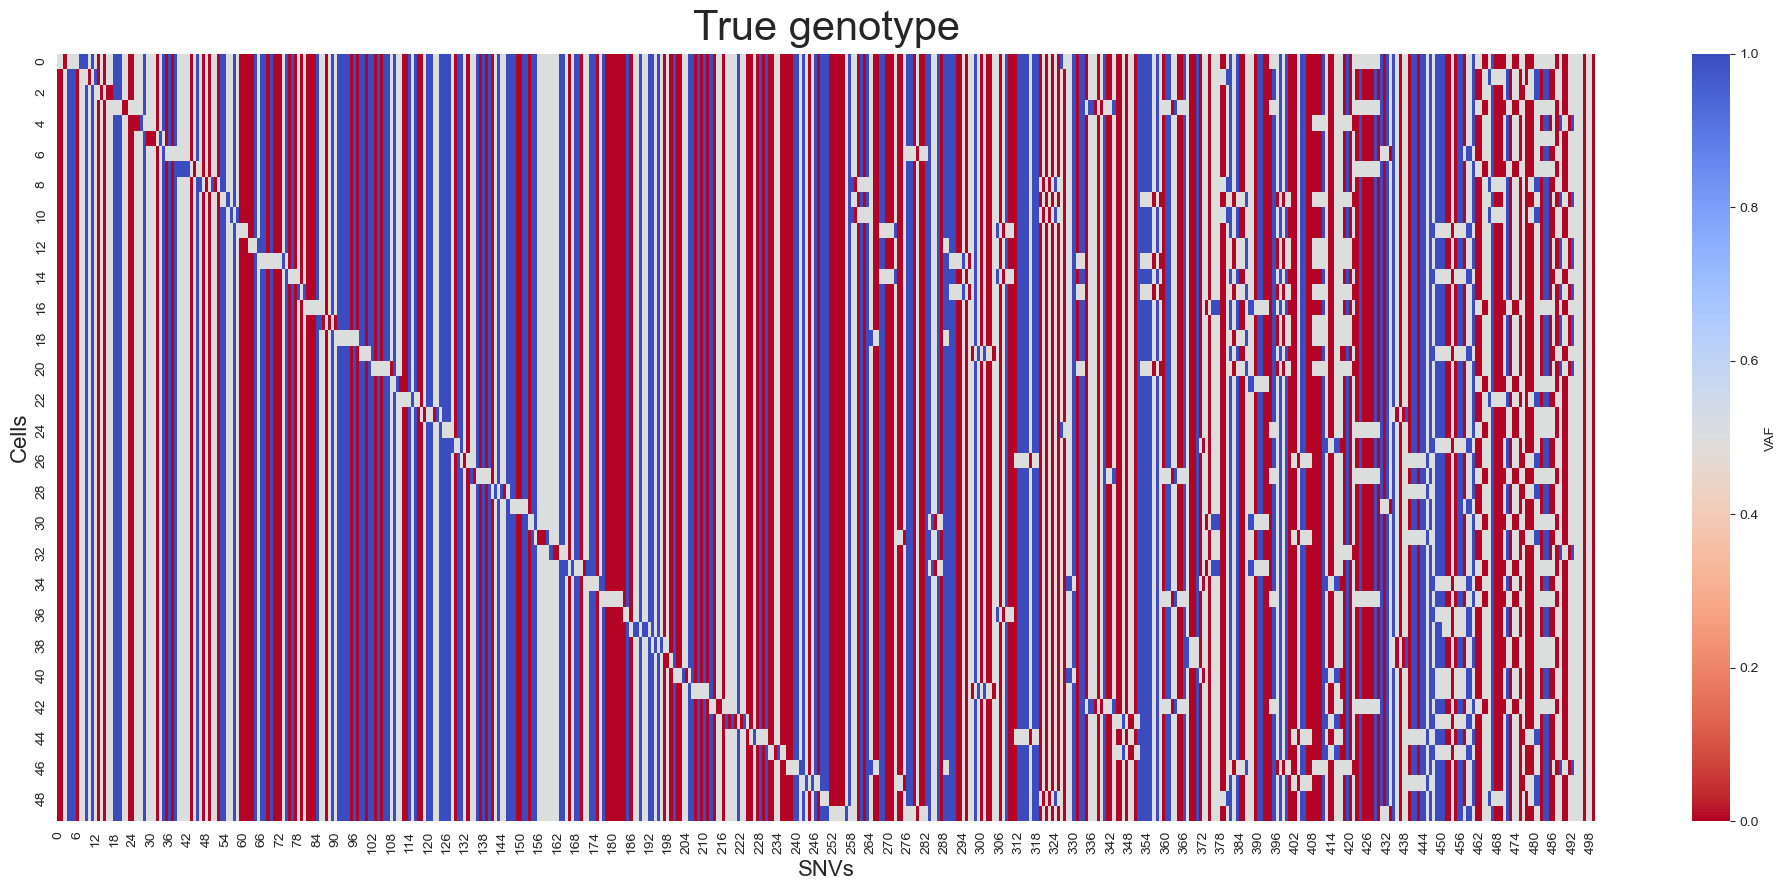

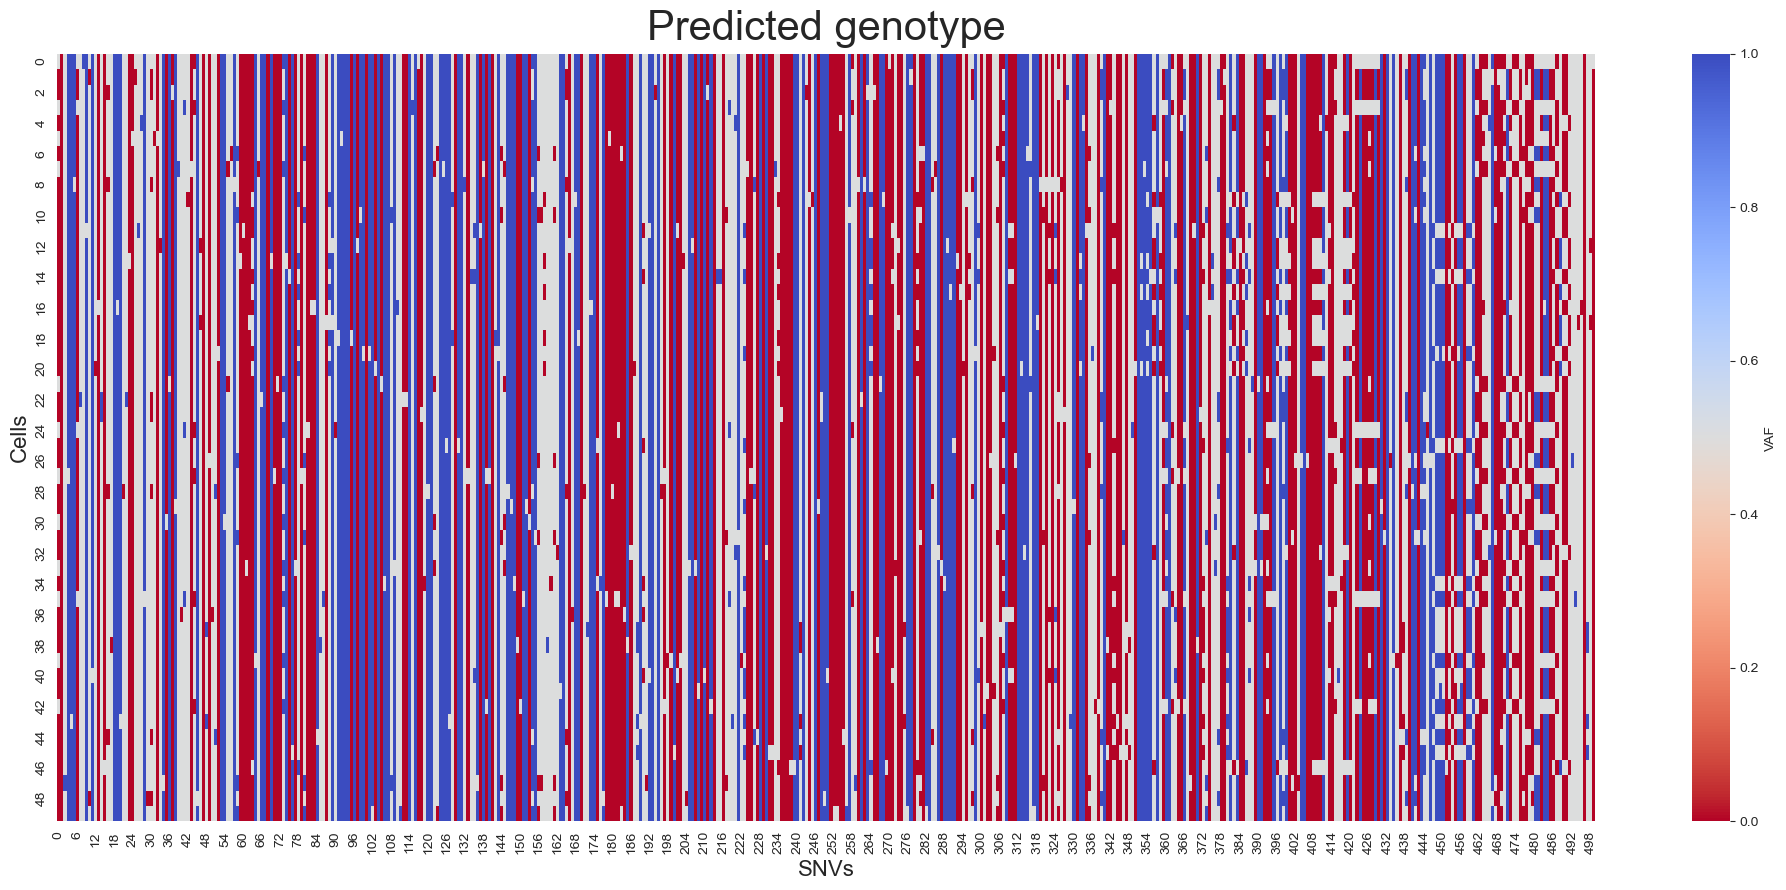

In [13]:
for t in range(n_tests-1, n_tests):
    alt = np.loadtxt(os.path.join(base_path, "alt", f"alt_{t}.txt"), dtype=int)
    ref = np.loadtxt(os.path.join(base_path, "ref", f"ref_{t}.txt"), dtype=int)
    mut_location = np.loadtxt(os.path.join(base_path, "mutation_location", f"mutation_location_{t}.txt"), dtype=int)
    selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
    genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str)
    sciterna_genotype = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt"), dtype=str)

    mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
    vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
    genotype_gt = vectorized_map(genotype_gt)
    genotype_predicted = vectorized_map(sciterna_genotype)
    # genotype_predicted = genotype_matrix
    # genotype_predicted = expected_genotype

    unique_sorted = np.sort(np.unique(mut_location))
    leaf_order = np.argsort([np.where(unique_sorted == x)[0][0] for x in mut_location])

    with np.errstate(divide='ignore', invalid='ignore'):
        vaf = alt / (ref + alt)

    vaf = vaf[:,leaf_order]
    genotype_gt = genotype_gt[:,leaf_order]
    genotype_predicted = genotype_predicted[:,leaf_order]

    # Define colormap: black for NaN, color gradient for valid values
    base_cmap = plt.get_cmap("coolwarm_r")  # Or 'coolwarm', 'RdYlBu'
    cmap_with_nan = base_cmap
    cmap_with_nan.set_bad(color='black')

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        vaf,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"Variant Allele Frequency (VAF)", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        genotype_gt,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"True genotype", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        genotype_predicted,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"Predicted genotype", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

In [15]:
genotype_differences["SClineager"] = {}
path_len_differences["SClineager"] = {}
likelihood_differences["SClineager"] = {}
mut_count_differences["SClineager"] = {}
adjusted_rand_index["SClineager"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")

                gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if gt.ndim == 1:
                    gt = gt[:, np.newaxis]

                _, clones_gt = np.unique(gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sclineager", "sclineager_clones", f"sclineager_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)


                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SClineager"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SClineager"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.0615406  mean abs difference of vafs predicted
3.4770367346938773  mean path length distance
4.956733547094189  mean mutation count distance
0.30685657237670205  mean adjusted rand index
0.092057  mean abs difference of vafs predicted
3.4067346938775516  mean path length distance
5.978912945891784  mean mutation count distance
0.17448442374401796  mean adjusted rand index
0.10159639999999999  mean abs difference of vafs predicted
3.459722448979592  mean path length distance
5.924432224448899  mean mutation count distance
0.07214220308430647  mean adjusted rand index
0.06307239999999999  mean abs difference of vafs predicted
3.635697959183673  mean path length distance
4.239179078156312  mean mutation count distance
1.0  mean adjusted rand index


In [16]:
genotype_differences["DENDRO"] = {}
path_len_differences["DENDRO"] = {}
likelihood_differences["DENDRO"] = {}
mut_count_differences["DENDRO"] = {}
adjusted_rand_index["DENDRO"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")

                gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if gt.ndim == 1:
                    gt = gt[:, np.newaxis]

                _, clones_gt = np.unique(gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)


                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.07196160000000001  mean abs difference of vafs predicted
3.465134693877551  mean path length distance
5.371226132264529  mean mutation count distance
0.1979496656765893  mean adjusted rand index
0.10280099999999999  mean abs difference of vafs predicted
3.4475510204081634  mean path length distance
6.361515270541081  mean mutation count distance
0.08313417572009413  mean adjusted rand index
0.10588139999999999  mean abs difference of vafs predicted
3.4496897959183674  mean path length distance
6.017979559118236  mean mutation count distance
0.0509068426078978  mean adjusted rand index
0.06307239999999999  mean abs difference of vafs predicted
3.547861224489796  mean path length distance
4.239179078156312  mean mutation count distance
1.0  mean adjusted rand index


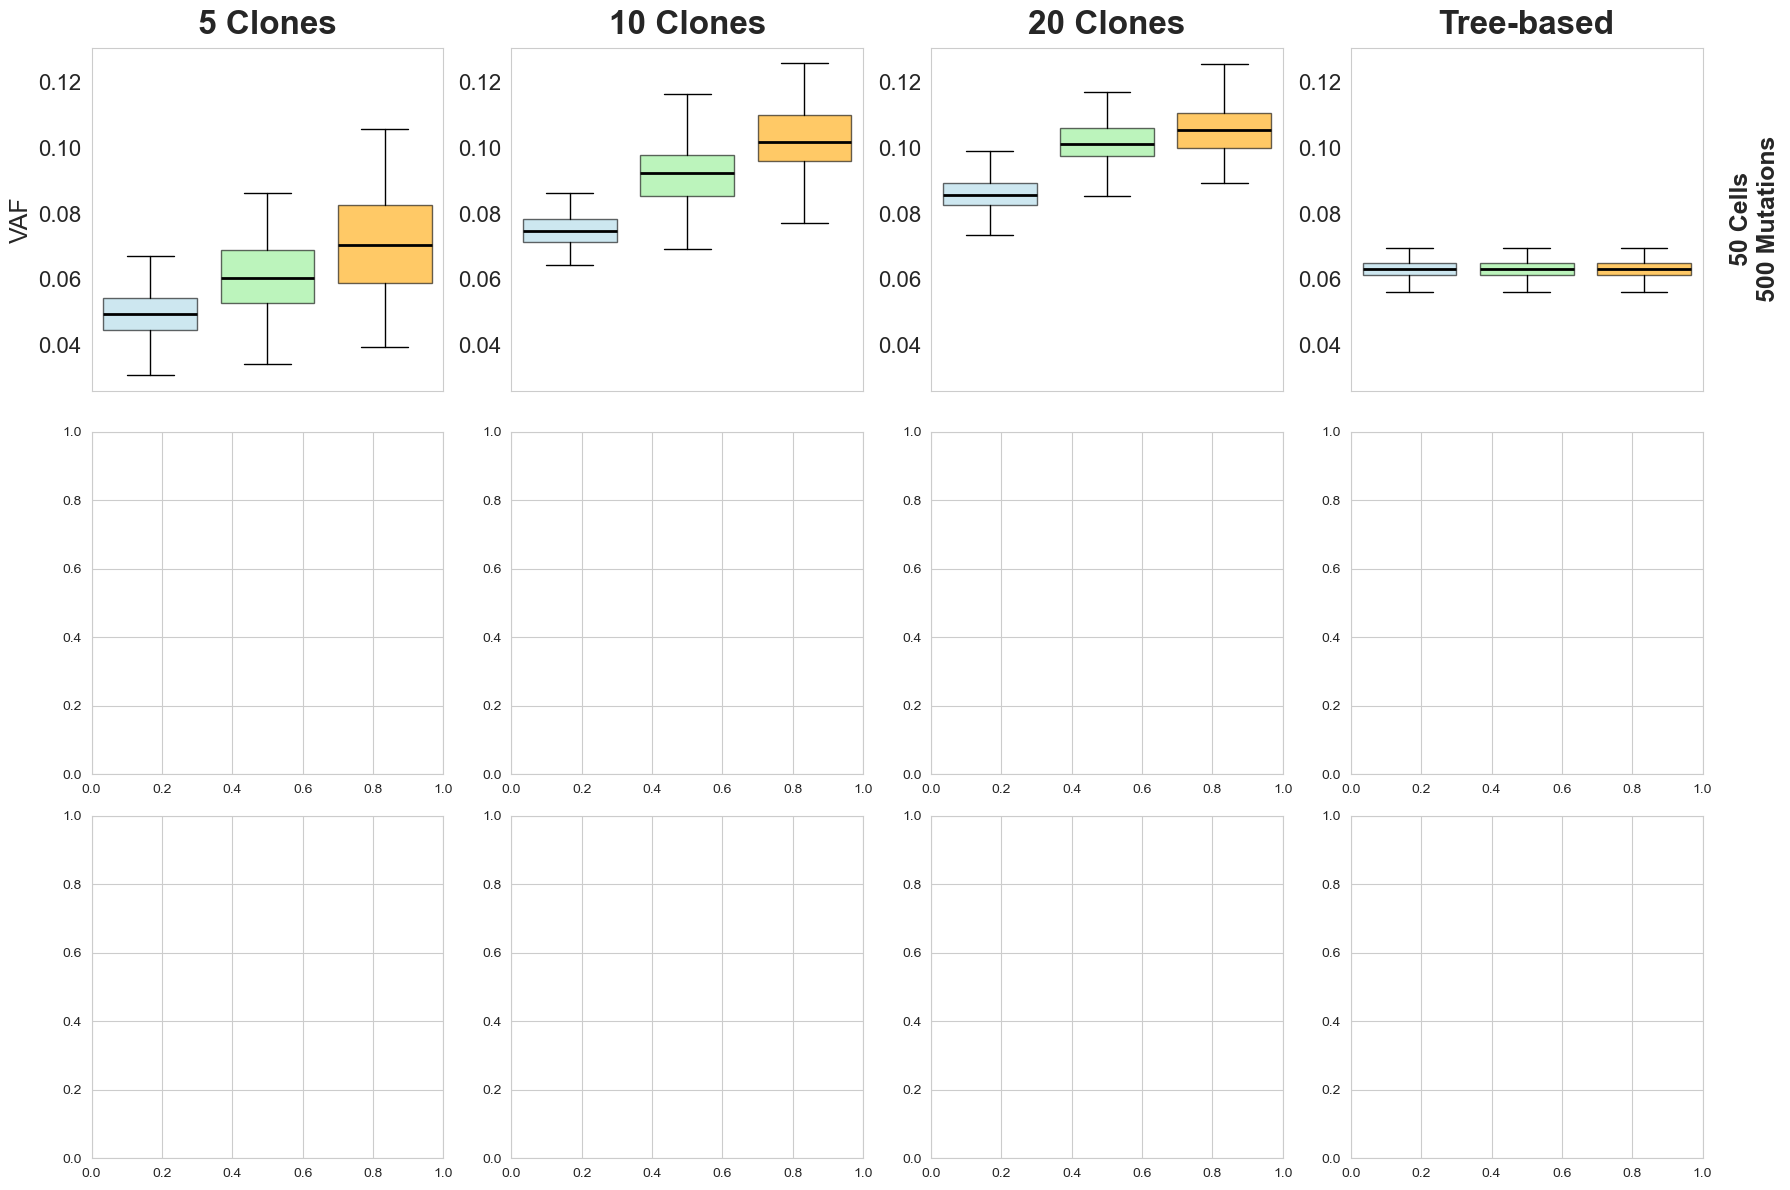

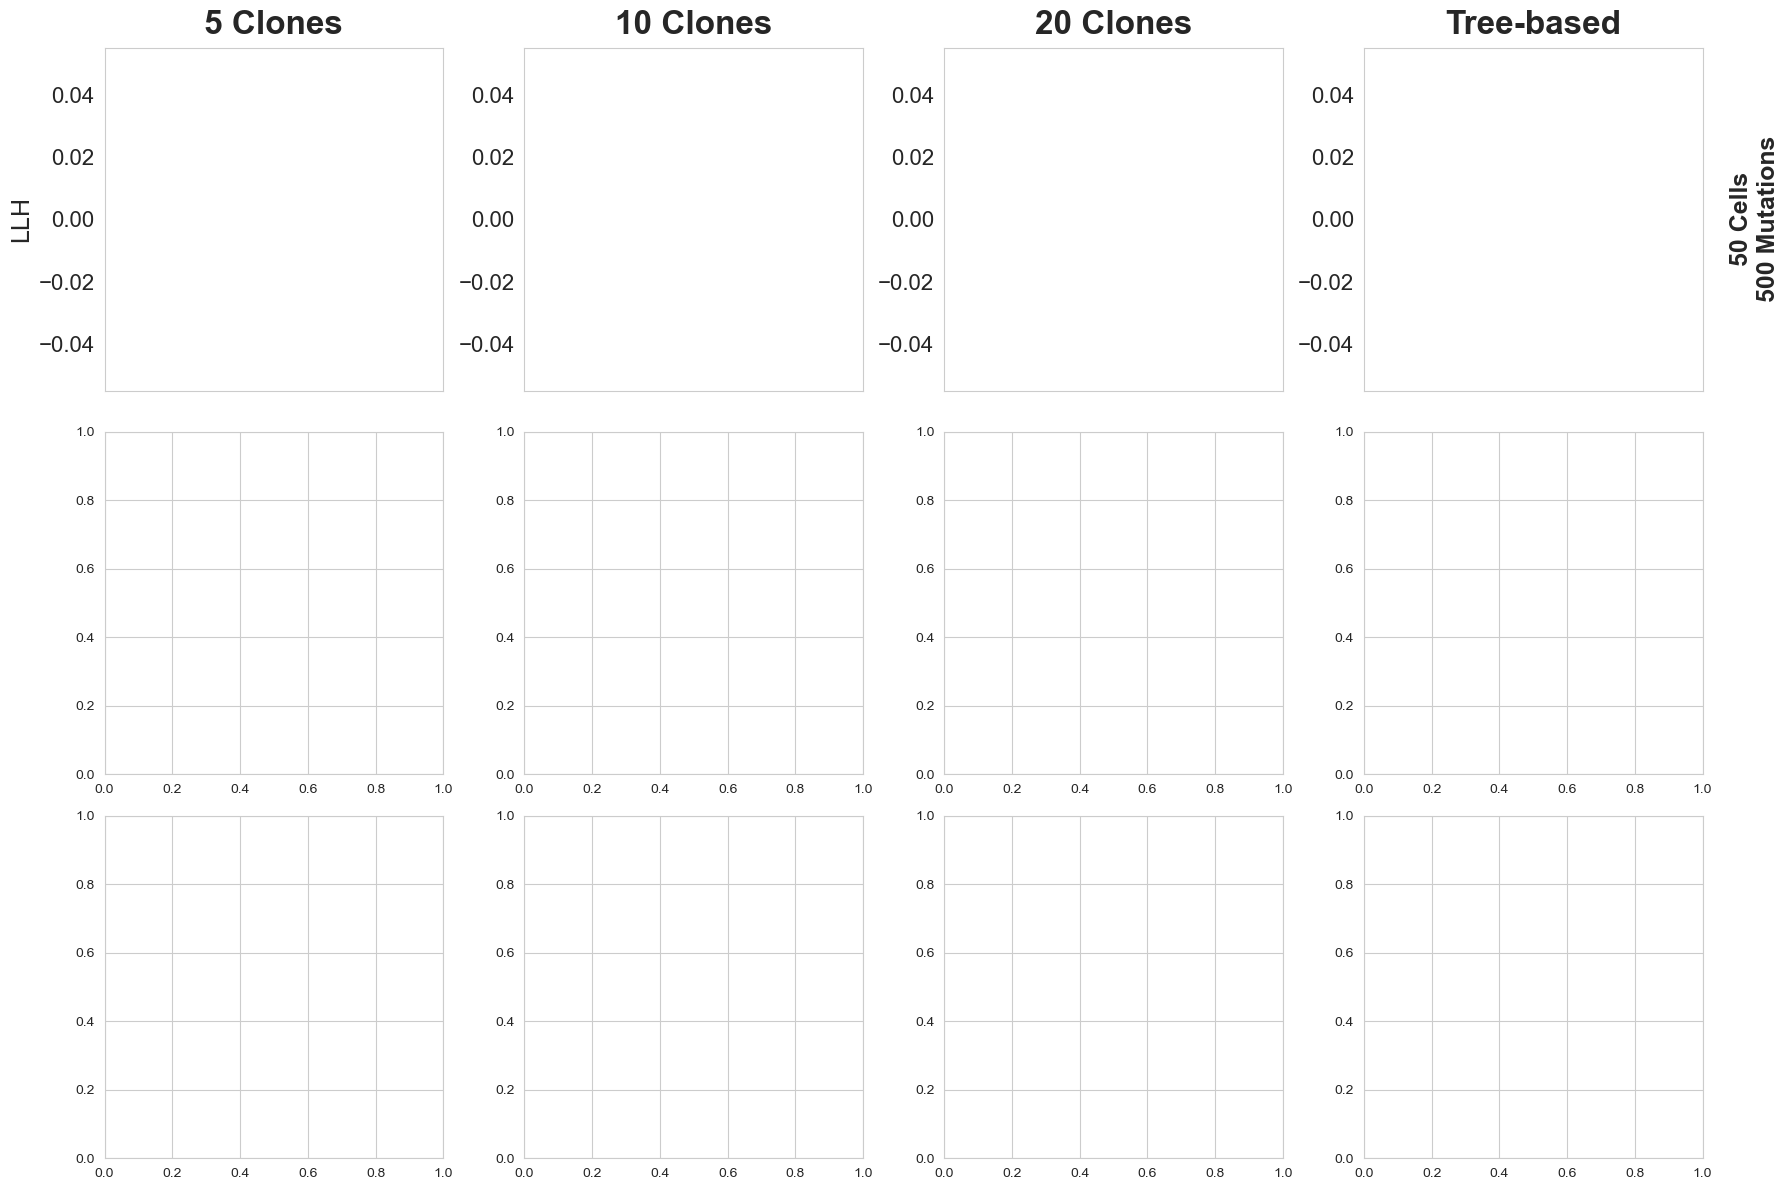

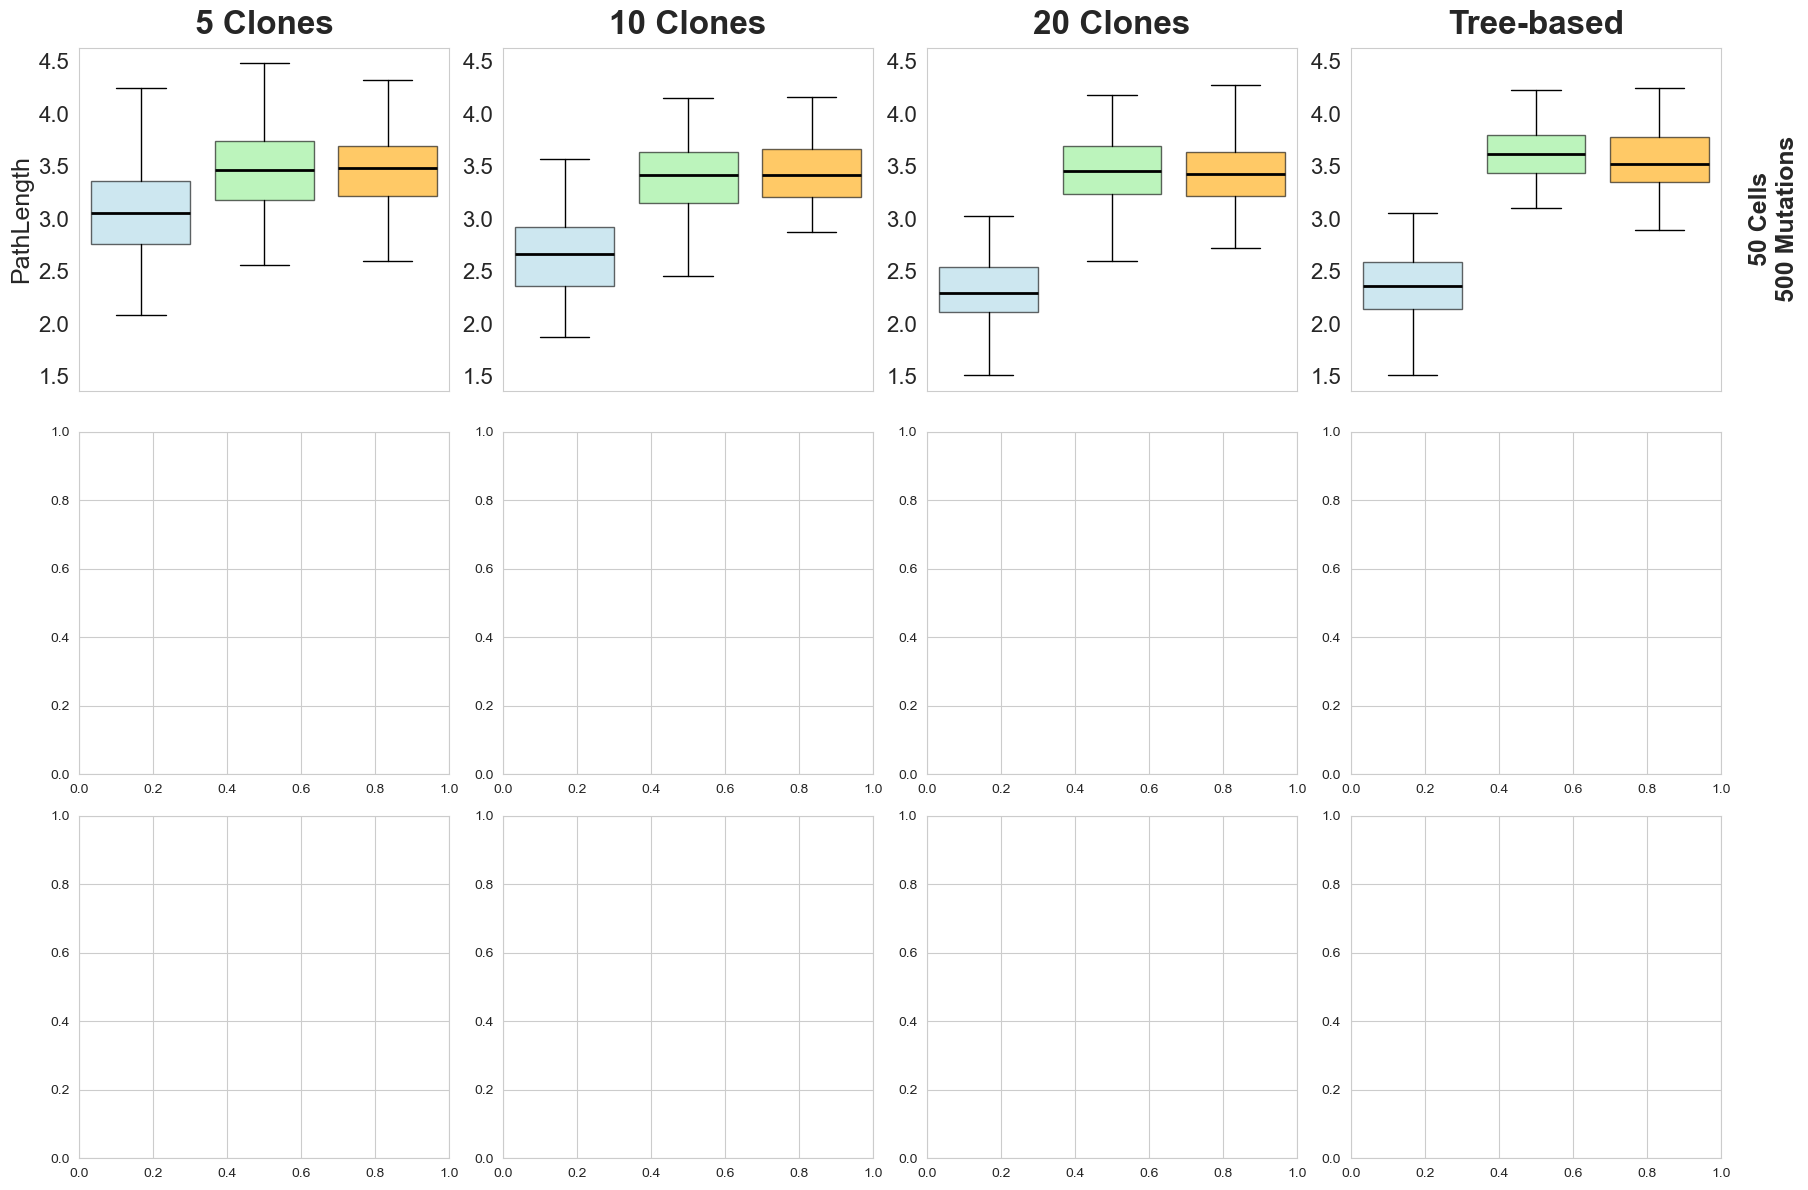

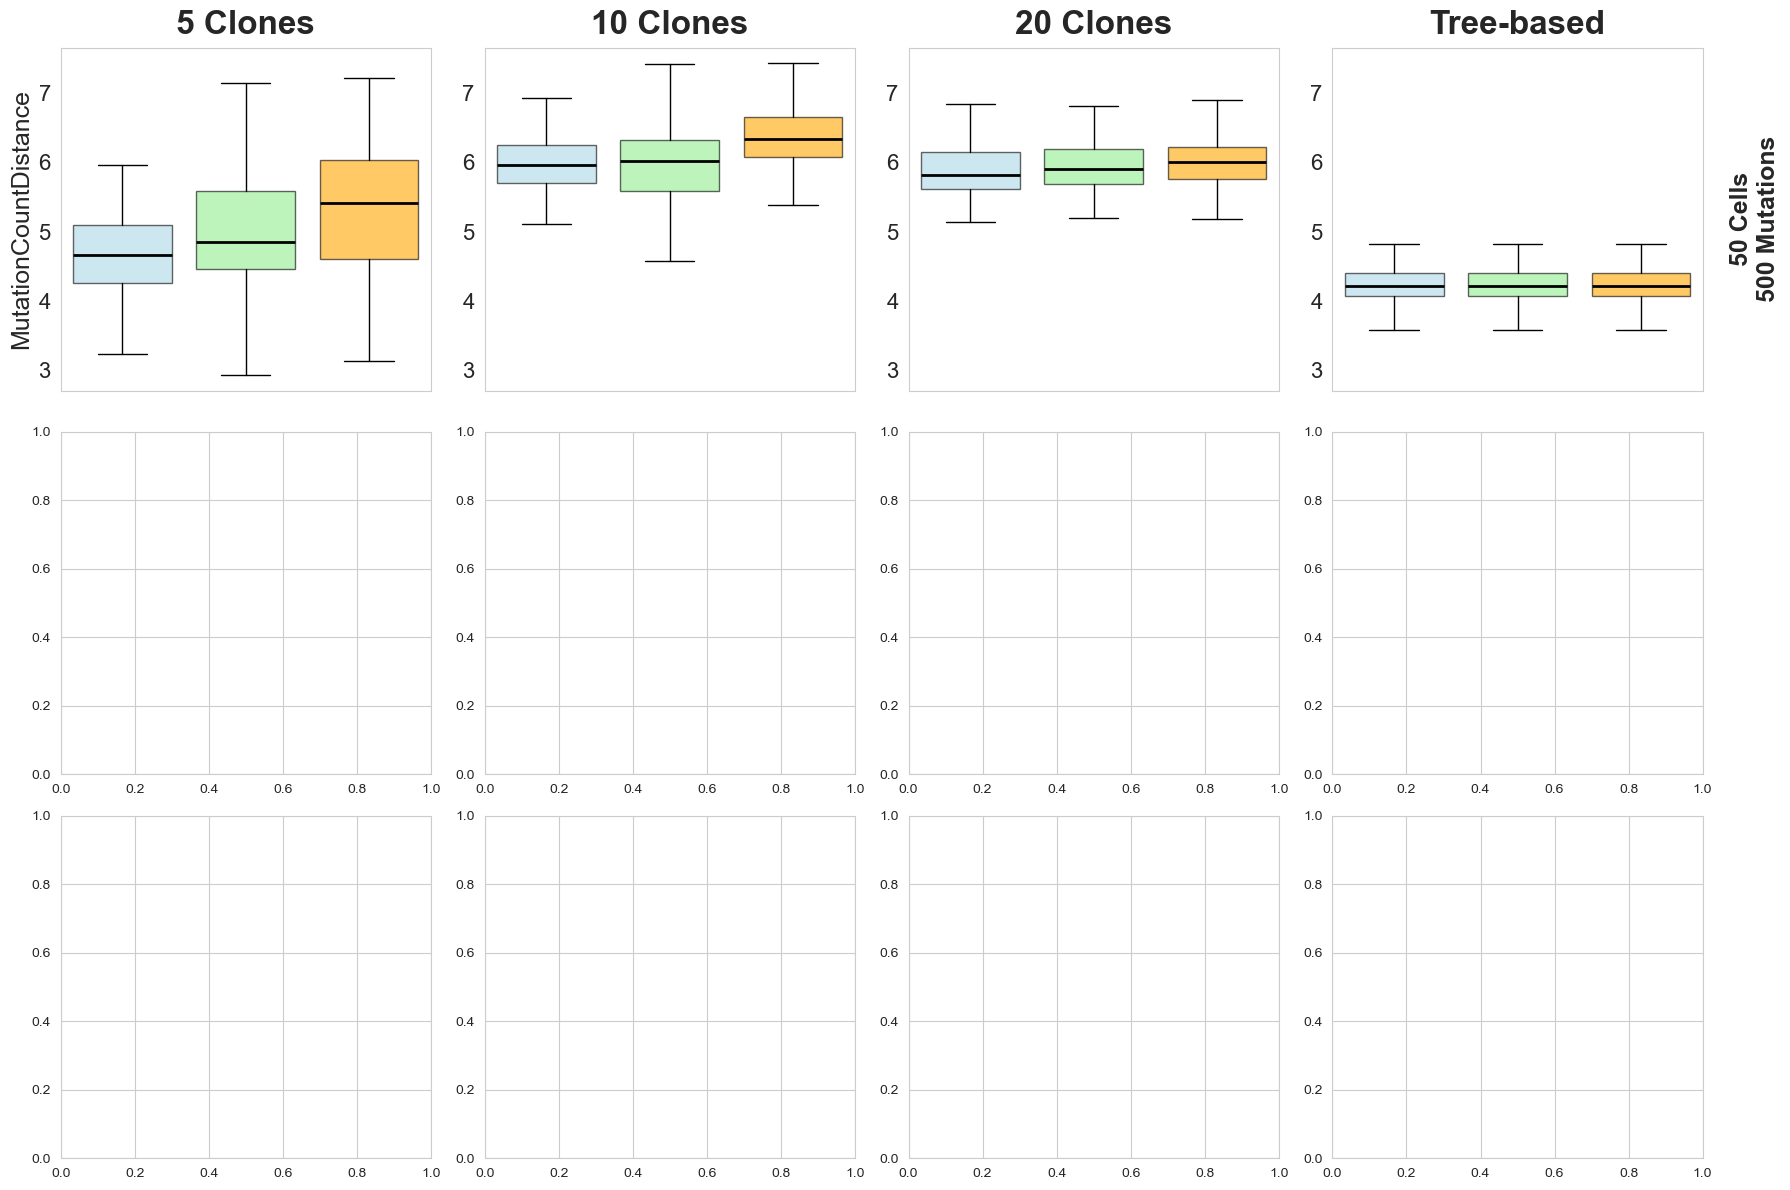

In [132]:
if use_summary_statistics:
    with open(r"../data/simulated_data/model_comparison.json") as f:
        genotype_differences = json.load(f)

def plot_results(results_data, title=""):
    models = ["SCITE-RNA", "SClineager", "DENDRO"]

    fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharey=False)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 24
    label_size = 18
    tick_size = 16
    box_width = 2.0
    boxplot_widths = 0.8

    row_y_limits = []

    for row_idx, (n_c, n_m) in enumerate(zip(n_cells, n_mut)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            all_samples = [results_data[model][f"{n_c}_{n_m}"][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            # Collect whisker data for row-level y-limit setting
            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == 2:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(f'{title}', fontsize=label_size)
            if col_idx == 3:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f'{n_c} Cells\n{n_m} Mutations', fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)

        # After processing all columns in a row, set common y-limits
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin -= 0.05 * yrange
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(len(clones)):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f"../data/results/figures/clones_{title}.png")
    plt.show()

plot_results(genotype_differences, "VAF")
plot_results(likelihood_differences, "LLH")
plot_results(path_len_differences, "PathLength")
plot_results(mut_count_differences, "MutationCountDistance")

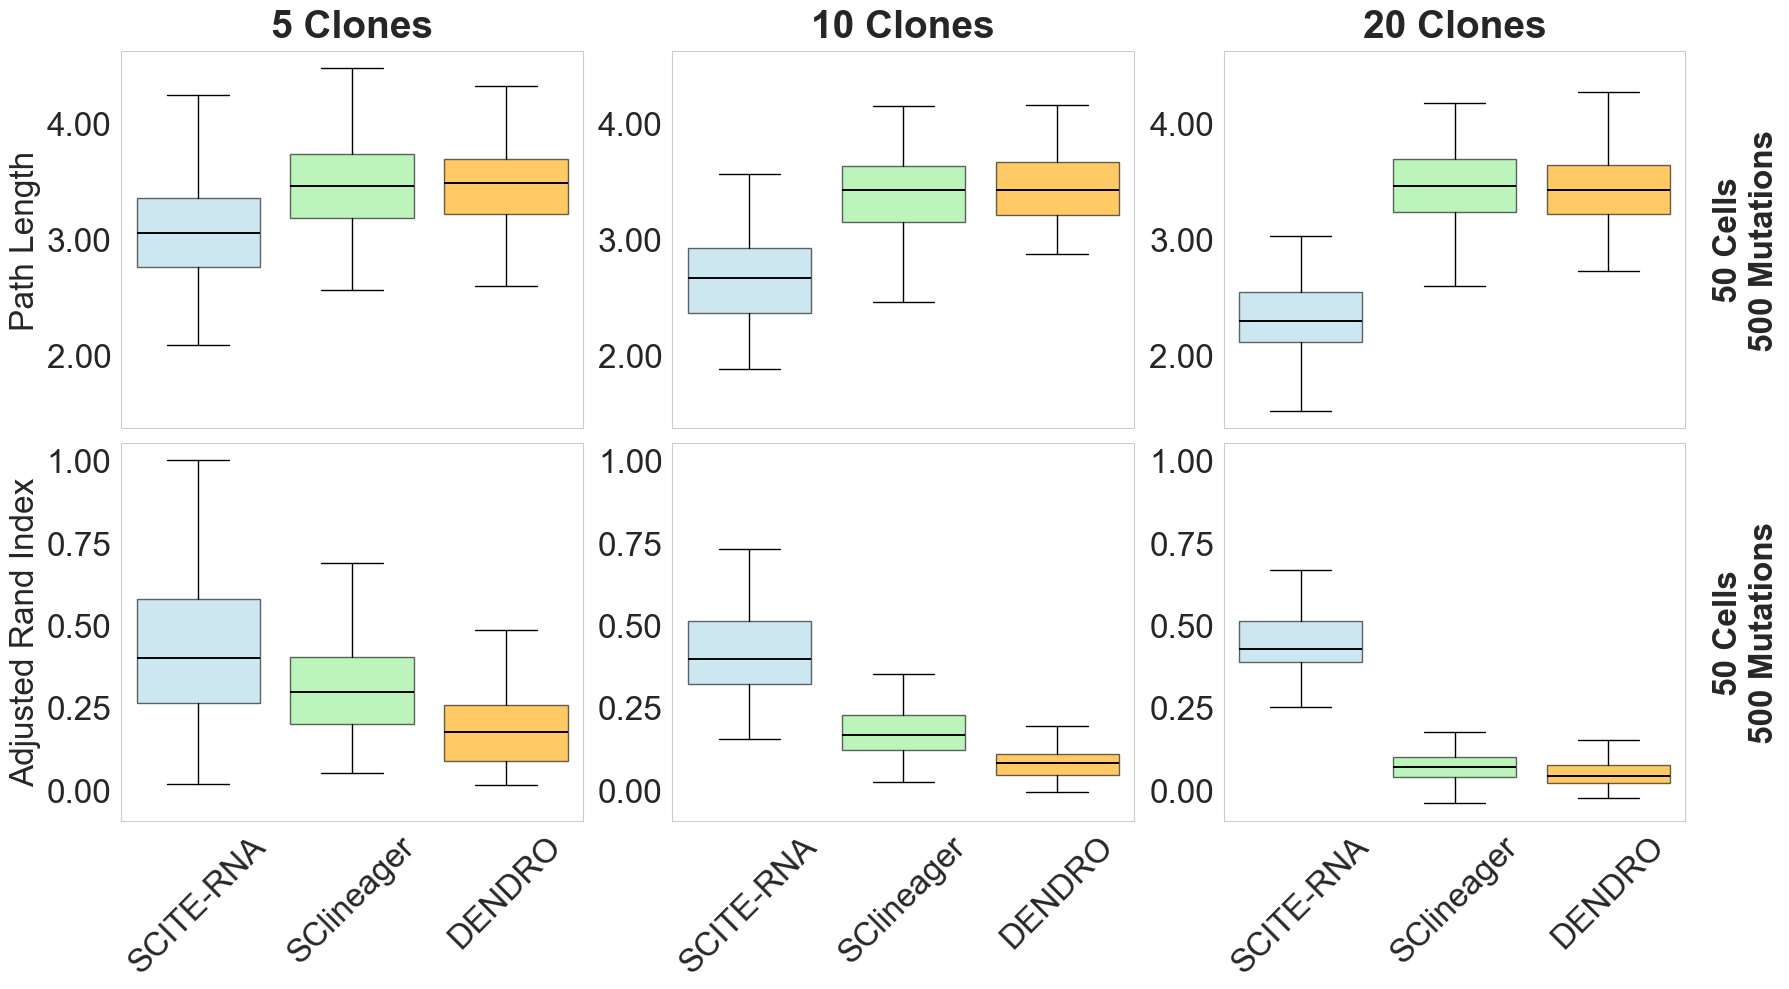

In [29]:
def plot_combined_vaf_pathlength(vaf_data, pathlen_data, clones, models=["SCITE-RNA", "SClineager", "DENDRO"]):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.font_manager import FontProperties

    # Configuration
    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = 2
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 10), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 28
    label_size = 24
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Length", "Adjusted Rand Index"]
    data_list = [vaf_data, pathlen_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [data[model][sample_key][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin -= 0.05 * yrange
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig("../data/results/figures/combined_PathLength_AdjustedRandIndex.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, adjusted_rand_index, [5, 10, 20])

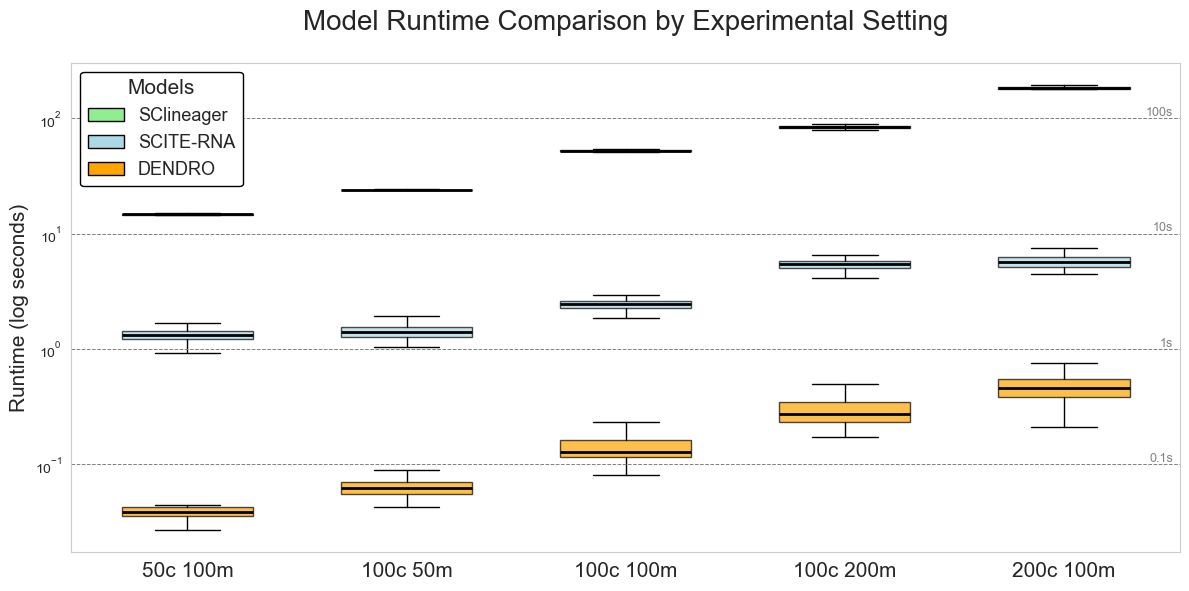

In [115]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

n_cells = [50, 100, 100, 100, 200]
n_mut = [100, 50, 100, 200, 100]
path = "../data/simulated_data/"
clone = ""
stratified = ""
models = ["SClineager", "SCITE-RNA", "DENDRO"]
colors = ["lightgreen", "lightblue", "orange"]

# Store runtimes per model per condition
runtime_data = {model: [] for model in models}
conditions = []

# Collect runtime data
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c {n_m}m"
    conditions.append(condition_label)

    base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
    try:
        scite_rna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_runtimes.txt"))
        sclineager = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_runtimes.txt"))
        dendro = np.loadtxt(os.path.join(base_path, "dendro", "dendro_runtimes.txt"))
    except Exception as e:
        print(f"Error loading data for {condition_label}: {e}")
        continue

    runtime_data["SCITE-RNA"].append(scite_rna)
    runtime_data["SClineager"].append(sclineager)
    runtime_data["DENDRO"].append(dendro)

fig, ax = plt.subplots(figsize=(12, 6))

positions = []
box_data = []
group_spacing = 2
box_width = 1.2

tick_positions = []
tick_labels = []

# Organize data for plotting
for idx, condition in enumerate(conditions):
    group_positions = []
    for offset, model in enumerate(models):
        pos = idx * group_spacing # + offset
        positions.append(pos)
        group_positions.append(pos)
        box_data.append(runtime_data[model][idx])

    tick_center = np.mean(group_positions)
    tick_positions.append(tick_center)
    tick_labels.append(condition)

# Plot boxplots
box = ax.boxplot(box_data, positions=positions, widths=box_width, patch_artist=True, showfliers=False)

# Color boxes
for patch, color in zip(box["boxes"], [colors[i % 3] for i in range(len(box_data))]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Style medians
for line in box['medians']:
    line.set_color("black")
    line.set_linewidth(2.0)

# Axis formatting
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=15)
ax.set_ylabel("Runtime (log seconds)", fontsize=15)
ax.set_title("Model Runtime Comparison by Experimental Setting", fontsize=20, y=1.05)
ax.set_yscale("log")
ax.grid(False)

reference_lines = [0.1, 1, 10, 100]
for y in reference_lines:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    ax.text(len(conditions)*group_spacing - 1, y, f'{y}s', va='bottom', ha='right', fontsize=9, color='gray', zorder=1)

# Add legend
legend_patches = [Patch(facecolor=colors[i], edgecolor='black', label=models[i]) for i in range(len(models))]
ax.legend(handles=legend_patches, title="Models", loc='upper left', fontsize=13, title_fontsize=15, facecolor='white', framealpha=1.0, edgecolor='black')

plt.tight_layout()
# plt.savefig("../data/results/figures/model_runtime_comparison.pdf")
plt.show()